##Setup

In [ ]:
!pip install pretty_midi
!sudo apt install -y fluidsynth
!pip install --upgrade pyfluidsynth

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libfluidsynth1 libqt5x11extras5 qsynth
Suggested packages:
  fluid-soundfont-gs timidity jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libfluidsynth1 libqt5x11extras5 qsynth
0 upgraded, 5 newly installed, 0 to remove and 37 not upgraded.
Need to get 120 MB of archives.
After this operation, 150 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fluid-soundfont-gm all 3.1-5.1 [119 MB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libfluidsynth1 amd64 1.1.9-1 [137 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fluidsynth amd64 1.1.9-1 [20.7 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libqt5x11extras5 amd64 5.9.5-0ubuntu1 [8,596 B]
Get:5 http://archive.ubuntu.com/ubuntu bionic/uni

In [ ]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf
import files

from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

In [ ]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

##Retrieve Maestro Dataset

In [ ]:
data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

59252736/59243107 [==============================] - 1s 0us/step


In [ ]:
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1282


##MIDI Processing

###Parsing

In [ ]:
sample_file = filenames[1]
print(sample_file)
pm = pretty_midi.PrettyMIDI(sample_file)

data/maestro-v2.0.0/2009/MIDI-Unprocessed_07_R2_2009_01_ORIG_MID--AUDIO_07_R2_2009_07_R2_2009_02_WAV.midi


Playing 30 second sample

In [ ]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [ ]:
display_audio(pm)

Inspection and exploration

In [ ]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Acoustic Grand Piano


###Note Extraction

Sample

In [ ]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=60, note_name=C4, duration=1.5612
1: pitch=68, note_name=G#4, duration=1.9297
2: pitch=51, note_name=D#3, duration=1.9180
3: pitch=44, note_name=G#2, duration=2.1732
4: pitch=68, note_name=G#4, duration=0.8633
5: pitch=67, note_name=G4, duration=0.6055
6: pitch=70, note_name=A#4, duration=0.7148
7: pitch=61, note_name=C#4, duration=1.8880
8: pitch=51, note_name=D#3, duration=1.8919
9: pitch=46, note_name=A#2, duration=2.0612


Functionized

In [ ]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [ ]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,60,1.009115,2.570312,0.000000,1.561198
1,68,1.018229,2.947917,0.009115,1.929688
2,51,1.058594,2.976562,0.040365,1.917969
3,44,1.058594,3.231771,0.000000,2.173177
4,68,4.042969,4.906250,2.984375,0.863281


COnverting pitch to note representations

In [ ]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['C4', 'G#4', 'D#3', 'G#2', 'G#4', 'A#2', 'C#4', 'D#3', 'G4', 'A#4'],
      dtype='<U3')

###Piano Roll Vizualization

In [ ]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

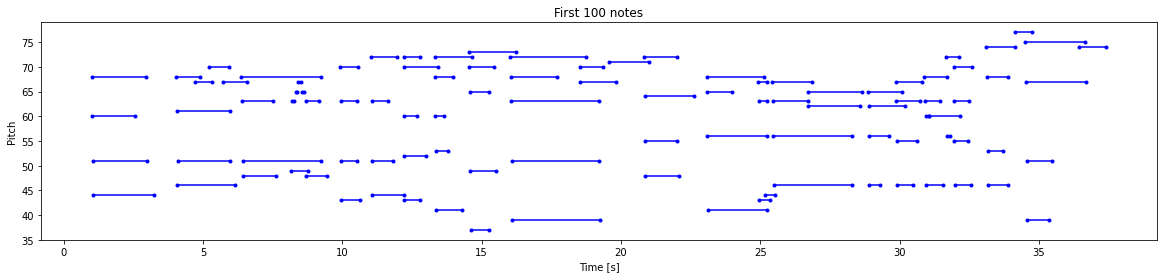

In [ ]:
plot_piano_roll(raw_notes, count=100)

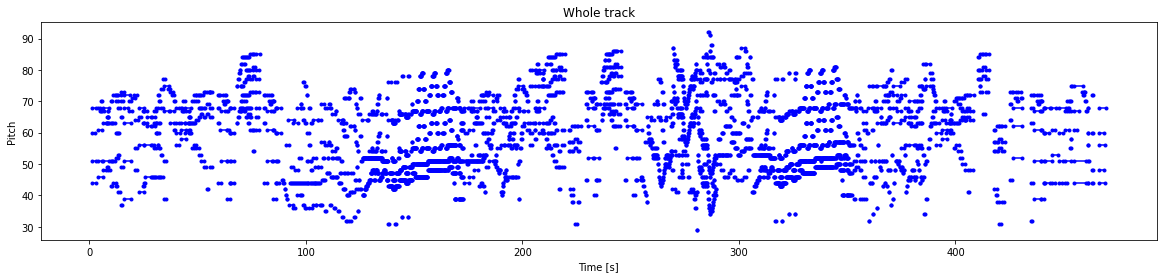

In [ ]:
plot_piano_roll(raw_notes)

###Midi Extraction from Notes (vice-versa)

In [ ]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

Converting raw sample note vector back to midi

In [ ]:
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

In [ ]:
display_audio(example_pm)

In [ ]:
# files.download(example_file)

NameError: ignored

##Creating a Training Dataset

In [ ]:
num_files = 10
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 47149


Create TensorFLow Dataset from Pandas DataFrame

In [ ]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

We'll train the model on batches of sequences of notes. Each example will consist of a sequence of notes as the input features, and next note as the label. In this way, the model will be trained to predict the next note in a sequence.

In [ ]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

W set the sequence length for each example. The size of the vocabulary (vocab_size) is set to 128 representing all the pitches supported by pretty_midi.

In [ ]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'duration': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None)})

The shape of the dataset is (100,1), meaning that the model will take 100 notes as input, and learn to predict the following note as output.

In [ ]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[0.5546875  0.         0.88671875]
 [0.40625    0.19661458 0.08984375]
 [0.4375     0.00130208 0.06770833]
 [0.4609375  0.01953125 0.05208333]
 [0.4609375  0.17838542 0.04427083]
 [0.40625    0.01302083 0.05208333]
 [0.4375     0.00260417 0.0390625 ]
 [0.4375     0.1484375  0.03645833]
 [0.40625    0.015625   0.04036458]
 [0.4609375  0.00651042 0.03645833]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=57.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.19401041666666696>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.06901041666666652>}


Batchify Data

In [ ]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

##Create and trian an RNN Model

The model will have three outputs, one for each note variable (pitch, step, duration).

Defining a loss function to remove negative value outputs

In [ ]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [ ]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.01,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 25, 3)]      0                                            
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 128)          67584       input_4[0][0]                    
__________________________________________________________________________________________________
duration (Dense)                (None, 1)            129         lstm_3[0][0]                     
__________________________________________________________________________________________________
pitch (Dense)                   (None, 128)          16512       lstm_3[0][0]                     
____________________________________________________________________________________________

In [ ]:
losses = model.evaluate(train_ds, return_dict=True)
losses

736/736 [==============================] - 13s 16ms/step - loss: 0.8120 - duration_loss: 0.7092 - pitch_loss: 4.8529 - step_loss: 0.0543


{'duration_loss': 0.7091687321662903,
 'loss': 0.811985433101654,
 'pitch_loss': 4.8528852462768555,
 'step_loss': 0.05428771302103996}

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [ ]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50
736/736 [==============================] - 29s 37ms/step - loss: 0.1576 - duration_loss: 0.0790 - pitch_loss: 4.1534 - step_loss: 0.0370
Epoch 2/50
736/736 [==============================] - 27s 37ms/step - loss: 0.1507 - duration_loss: 0.0747 - pitch_loss: 4.0490 - step_loss: 0.0355
Epoch 3/50
736/736 [==============================] - 28s 38ms/step - loss: 0.1479 - duration_loss: 0.0732 - pitch_loss: 4.0213 - step_loss: 0.0345
Epoch 4/50
736/736 [==============================] - 28s 38ms/step - loss: 0.1452 - duration_loss: 0.0717 - pitch_loss: 3.9911 - step_loss: 0.0336
Epoch 5/50
736/736 [==============================] - 28s 38ms/step - loss: 0.1470 - duration_loss: 0.0731 - pitch_loss: 4.0096 - step_loss: 0.0338
Epoch 6/50
736/736 [==============================] - 28s 38ms/step - loss: 0.1418 - duration_loss: 0.0688 - pitch_loss: 3.9764 - step_loss: 0.0332
Epoch 7/50
736/736 [==============================] - 28s 38ms/step - loss: 0.1392 - duration_loss: 0.0674 - pit

Saving and reloading a model

In [ ]:
import datetime, os

# Create a function to save a model
def save_model(model, suffix=""):
  """
  Saves a given model in a models directory and appends a suffix (string).
  """
  modeldir = os.path.join("drive/MyDrive/oh-sheet/old/models",
                          datetime.datetime.now().strftime("%m%d-%H"))
  
  model_path = modeldir + ("-" + suffix if len(suffix) else None) + ".h5"
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

# Create a function to load a trained model
def load_model(model_path):
  """
  Loads a saved model from a specified path
  """
  print(f"Loading model from: {model_path}")
  model = tf.keras.models.load_model(model_path)
  return model

In [ ]:
save_model(model,"rnn")

Saving model to: drive/MyDrive/oh-sheet/old/models/0929-13-rnn.h5...


'drive/MyDrive/oh-sheet/old/models/0929-13-rnn.h5'